# **Práctico 3 y 4 (parte 5): De palabras a números**

### Tabla de Contenidos
1. [Consigna](#1.-Consigna)
2. [Inicialización del entorno](#2.-Inicialización-del-entorno)
3. [Carga de datos y limpieza](#3.-Carga-de-datos-y-limpieza)
4. [Selección de las columnas de interés](#4.-Selección-de-las-columnas-de-interés)
5. [Vectorización](#5.-Vectorización)
6. [Inspección del resultado de la vectorización](#6.-Inspección-del-resultado-de-la-vectorización)
7. [División y normalización de los datos](#7.-División-y-normalización-de-los-datos)
8. [Predicción usando árboles de decisión](#8.-Predicción-usando-árboles-de-decisión)
9. [Predicción usando Naive Bayes](#9.-Predicción-usando-Naive-Bayes)
10. [Exploración de hiperparámetros de CountVectorizer](#10.-Exploración-de-hiperparámetros-de-CountVectorizer)
11. [Conclusiones](#11.-Conclusiones)


## 1. Consigna

Los algoritmos de aprendizaje automático trabajan con espacios vectoriales (es decir, con muchos números). Entonces al trabajar con Procesamiento de Lenguaje Natural se plantea la cuestión de cómo representar texto con números. Hay muchas maneras de hacer esto y es un campo que sigue evolucionando con el tiempo. Una opción muy básica es asignarle a cada palabra que aparece en nuestro dataset un número según el orden en el que aparecen. Luego, una oración es un vector de índices de esas palabras. Pero esto tiene varios problemas. Entre ellos, los algoritmos de aprendizaje automático también requieren que los vectores tengan una longitud fija, con lo cual hay que recortar la oración o agregarle ceros al final (es decir, hacer padding). Por eso un enfoque clásico para representar texto es el Bag Of Words: un vector de bits del tamaño de todo nuestro vocabulario que tiene un uno si la palabra está en la oración y un 0 si no está. Este enfoque también se conoce como One Hot Vector. 

Referencias: 
1. https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras 

2. https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

3. https://towardsdatascience.com/the-magic-behind-embedding-models-part-1-974d539f21fd

Para la implementación podrían usar Spacy, como se usó para la tokenización. Sin embargo creo que va a ser más sencillo para uds usar la libreria CountVectorizer que implementa el Bag Of Words de forma eficiente considerando que es una representación esparsa. Esta sugerencia es porque uds ya vienen usando sklearn.

Con el objetivo de visualizar lo que hace CountVectorizer vamos a explorar sus hiperparámetros min_df, max_df y ngram-range. Observar cómo cambia el tamaño del vector.

Los parámetros min_df y max_df que se corresponden con min y max document frequency. Ámbos toman valores entre 0 y 1 y estipulan el rango de frecuencia de aparición de una palabra dentro de un documento que vamos a aceptar. Es decir, si min_df es 0.005, todas las palabras que representen menos de un 0,5% de las palabras totales serán descartadas. Por el otro lado, si max_df es 0.35, todas las palabras que representen más de un 35% del total de palabras serán descartadas. Visualizar las palabras que serían descartadas dentro de este rango y describir cómo son. 

El parámetro ngram_range calcula la frecuencia de ngramas. Resulta útil para descubrir frases o expresiones comunes (además de las palabras comunes). Además, en combinación con el parámetro "analyzer" se pueden usar como ngramas de palabras o de caracteres.

Referencias: 

4. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

5. De palabras a vectores por DOT CVS: https://www.youtube.com/watch?v=Tg1MjMIVArc


NOTA: Como el tamaño del vector (es decir, el vocabulario) debe ser igual para el entrenamiento como para el test y el dev, tenemos que vectorizar todos los dataset de la misma forma. 

## 2. Inicialización del entorno

In [87]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from ast import literal_eval
import re
import itertools

# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from yellowbrick.text import FreqDistVisualizer

# Para dividir el dataset en train  y test
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Para tratamiento de texto
from sklearn.feature_extraction.text import CountVectorizer

# Para el cálculo de tf y tf–idf 
from sklearn.feature_extraction.text import TfidfTransformer

# Algoritmo del Árbol de Decisión
from sklearn.tree import (DecisionTreeClassifier, plot_tree)

# Para utilizar Naive-Bayes para la clasificación
from sklearn.naive_bayes import MultinomialNB

# Para utilizar el algoritmo del gradiente descendiente
from sklearn.linear_model import SGDClassifier

# Para calcular métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report) 

# Para vectorizar los tokens
from sklearn.feature_extraction.text import CountVectorizer

## 3. Carga de datos y limpieza

El archivo **curated_data_para_nlp.csv** se genera a partir del archivo yup_messages_preprocessed.csv y datadump-20150801-20171219.csv y se cura para aplicar sobre el mismo técnicas de procesamiento del lenguaje natural.

In [100]:
# Desde Colab

#from google.colab import files   # para poder leer archivos que están en mi pc
#uploaded = files.upload()

In [101]:
# Desde el entorno local

filename = 'yup_curated_data.csv'
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))

In [102]:
# datos_curados= pd.read_csv('curated_data_para_nlp.csv')

print ('\nDimensiones del dataset\n')
print ('Filas: {}'.format(datos_curados.shape[0]))
print ('Columnas: {}'.format(datos_curados.shape[1]))


Dimensiones del dataset

Filas: 17429
Columnas: 22


#### **Limpieza: Remoción de las sesiones con pocos turnos del estudiante o del tutor**

Por considerarse que no se ha llevado a cabo un intercambio significativo se remueven las sesiones con menos de 3 turnos del estudiante o del tutor

In [103]:
n_short_sessions = len(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)])
datos_curados = datos_curados.drop(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)].index)

print('\nSe remueven {} sesiones con menos de 3 turnos del estudiante o del tutor\n'.format(n_short_sessions))


Se remueven 1124 sesiones con menos de 3 turnos del estudiante o del tutor



#### **Limpieza: Remoción de las sesiones con la columna de tokens del estudiante o del tutor nula**

Se remueven aquellos diálogos sin información en las columnas de tokens del tutor o del estudiante

In [104]:
n_null_token_tutor = datos_curados['tokens_tutor'].isnull().sum()
n_null_token_student = datos_curados['tokens_student'].isnull().sum()
datos_curados = datos_curados.dropna(subset=['tokens_tutor','tokens_student'])
print('\nSe remueven {} sesiones sin tokens del tutor'.format(n_null_token_tutor))
print('\nSe remueven {} sesiones sin tokens del estudiante'.format(n_null_token_student))


print ('\nDimensiones del dataset\n')
print ('Filas: {}'.format(datos_curados.shape[0]))
print ('Columnas: {}'.format(datos_curados.shape[1]))


Se remueven 0 sesiones sin tokens del tutor

Se remueven 0 sesiones sin tokens del estudiante

Dimensiones del dataset

Filas: 16305
Columnas: 22


#### **Limpieza: Unificación de las expresiones algebraicas bajo el tag math**

In [105]:
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: literal_eval(x))
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: literal_eval(x))

In [106]:
# Los unigramas que contienen al menos un dígito y al menos un operador algebraico se unifican bajo el tag <math> 
# usando una expresión regular

r = re.compile('((?=.*[0-9])(?=.*[%\/\(\)\^\\\+\-\*\=]))^.*')
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: ['<math>' if r.match(w) else w for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: ['<math>' if r.match(w) else w for w in x])

In [107]:
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: str(x)[1:-1])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: str(x)[1:-1])

#### **Primeras filas de la columna 'tokens_tutor', la cual contiene texto de interés para el análisis.**

In [108]:
datos_curados['tokens_tutor'].head()

0    'Hey', 'Robert', '!', 'Welcome', 'to', 'Yup', ...
1    '', 'Hello', 'Sophie', ',', 'Welcome', 'to', '...
2    'Hello', 'Illuminati', '.', ':)', 'Welcome', '...
3    'Hi', 'there', 'Domingo', '!', 'Welcome', 'to'...
4    'Hello', '', 'Jasmyn', '', ':)', 'Welcome', 't...
Name: tokens_tutor, dtype: object

#### **Primeras filas de la columna 'tokens_student', la cual contiene texto de interés para el análisis.**

In [109]:
datos_curados['tokens_student'].head()

0    '<url>', 'I', "'ve", 'only', 'tried', 'simplif...
1    '<url>', 'hello', 'I', 'was', 'confused', 'wit...
2    '<url>', 'Hello', 'All', 'three', 'Yes', ':)',...
3    '<url>', 'Okz', 'no', 'problem', 'Yes', 'that'...
4    '<url>', 'thank', 'you', '!', ':)', 'no', 'pro...
Name: tokens_student, dtype: object

## 4. Selección de las columnas de interés

- `tokens_student`: texto de los turnos del estudiante.
- `tokens_tutor`: texto de los turnos del tutor.
- `student_rating_cat`: columna calculada a partir de la calificación asignada por el alumno a la sesión: '0 - Negativa', '1 - Positiva'

In [167]:
#datos_curados['tokens'] = datos_curados['tokens_tutor'] +', '+ datos_curados['tokens_student']
#df_X=datos_curados['tokens']

df_X=datos_curados['tokens_tutor']

#df_X=datos_curados['tokens_student']

df_y=datos_curados['student_rating_cat'] 
print('Longitud de df_X:', len(df_X), ' y Longitud de df_y:', len(df_y))

Longitud de df_X: 16305  y Longitud de df_y: 16305


## **Bolsa de palabras para clasificación**

## 5. Vectorización

Utilizando el objeto CountVectorizer convertimos el texto en vectores numéricos.

In [151]:
# trabajamos con CountVectorizer sin parámetros por defecto

vectorizer = CountVectorizer()
X_cv = vectorizer.fit_transform(df_X)         

# Dimensión de la matriz dispersa
print('Dimensión de la matriz dispersa \n')
X_cv.shape

Dimensión de la matriz dispersa 



(16305, 35743)

## 6. Inspección del resultado de la vectorización

#### **Vocabulario**

In [152]:
# Primeros 20 elementos del vocabulario
dict(itertools.islice(vectorizer.vocabulary_.items(), 20))

{'hey': 17828,
 'robert': 28148,
 'welcome': 34337,
 'to': 32369,
 'yup': 35501,
 'am': 7679,
 'looking': 21294,
 'over': 24715,
 'your': 35429,
 'problem': 26244,
 've': 33779,
 'reviewed': 27921,
 'on': 24290,
 'finding': 15926,
 'the': 31853,
 'domain': 13894,
 'of': 24019,
 'square': 30337,
 'root': 28213,
 'function': 16520}

#### **Valores de la matriz dispersa**

In [153]:
# imprimimos lo valores de la matriz dispersa
print(X_cv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### **Valores de los primeros features**

In [154]:
# Valores de los 20 primeros features
vectorizer.get_feature_names()[:20]

['00',
 '000',
 '0000',
 '000000',
 '0000000',
 '000000000',
 '0000000000000000000000004',
 '0000000000000000000004',
 '00000000001',
 '000000000035',
 '0000000001',
 '000000000667',
 '000000001',
 '00000000227',
 '00000001',
 '000000010',
 '00000004290224',
 '0000001',
 '000000227',
 '000000333']

## 7. División y normalización de los datos

1. El conjunto de datos es dividido en datos de entrada o alimentación y en la referencia o target al cual debe apuntar el clasificador al momento de predecir.

2. Se divide nuevamente al conjunto de datos en datos de entrenamiento o train y datos de evaluación o test, cada uno de ellos con su correspondiente referencia o target.

In [155]:
# División entre instancias y etiquetas
X, y = X_cv, df_y     

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('\nLongitud del conjunto de entrenamiento: {}'.format(X_train.shape[0]))
print('Longitud del conjunto de test: {}'.format(X_test.shape[0]))


Longitud del conjunto de entrenamiento: 13044
Longitud del conjunto de test: 3261


## 8. Predicción usando árboles de decisión

#### **Árbol de decisión**

In [156]:
arbol_decision = DecisionTreeClassifier(random_state = 42) # para que coincida con el random_state elegido para SGD
print('Parámetros utilizados: \n', np.array(list(arbol_decision.get_params(deep=False).items())))

Parámetros utilizados: 
 [['ccp_alpha' 0.0]
 ['class_weight' None]
 ['criterion' 'gini']
 ['max_depth' None]
 ['max_features' None]
 ['max_leaf_nodes' None]
 ['min_impurity_decrease' 0.0]
 ['min_impurity_split' None]
 ['min_samples_leaf' 1]
 ['min_samples_split' 2]
 ['min_weight_fraction_leaf' 0.0]
 ['presort' 'deprecated']
 ['random_state' 42]
 ['splitter' 'best']]


#### **Entrenamiento**

El modelo es entrenado con los parámetros que posee la implementación por defecto, dicho proceso consume el conjunto de datos de entrenamiento y su correspondiente referencia.

In [157]:
arbol_decision.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### **Predicción con el conjuto de datos de entrenamiento y test**


Se lleva a cabo el proceso de predicción tomando como entrada al modelo

- El conjunto de datos de entrenamiento
- El conjunto de datos de test

In [158]:
#1. Predicción con el conjunto de datos de entrenamiento
y_train_pred_arbolD = arbol_decision.predict(X_train)
y_train_pred_arbolDp = arbol_decision.predict_proba(X_train)

In [159]:
#1. Predicción con el conjunto de datos de test
y_test_pred_arbolD  = arbol_decision.predict(X_test)
y_test_pred_arbolDp = arbol_decision.predict_proba(X_test)

#### **Verificamos la accuracy obtenida.**

#### Accuracy con train

In [160]:
print ('Accuracy: %d ' % ((np.sum(y_train == y_train_pred_arbolD))/float(y_train.size)*100))

Accuracy: 100 


#### Accuracy con test

In [161]:
print ('Accuracy: %d ' % ((np.sum(y_test == y_test_pred_arbolD))/float(y_test.size)*100))

Accuracy: 77 


In [162]:
print('Profundidad máxima del árbol:', arbol_decision.get_depth())
print('Cantidad máxima de hojas:', arbol_decision.get_n_leaves())

Profundidad máxima del árbol: 85
Cantidad máxima de hojas: 1276


In [163]:
# Classification report
print(classification_report(y_test, y_test_pred_arbolD))

              precision    recall  f1-score   support

           0       0.38      0.33      0.35       616
           1       0.85      0.88      0.86      2645

    accuracy                           0.77      3261
   macro avg       0.61      0.60      0.61      3261
weighted avg       0.76      0.77      0.77      3261



## 9. Predicción usando Naive Bayes

In [164]:
# 
naive_bayes = MultinomialNB(alpha=0.0, class_prior=[0.3, 0.7])
naive_bayes.fit(X_train, y_train)

MultinomialNB(alpha=0.0, class_prior=[0.3, 0.7])

In [165]:
y_train_pred_NB = naive_bayes.predict(X_train)
y_test_pred_NB = naive_bayes.predict(X_test)

In [166]:
print(classification_report(y_test, y_test_pred_NB))

              precision    recall  f1-score   support

           0       0.41      0.47      0.44       616
           1       0.87      0.84      0.86      2645

    accuracy                           0.77      3261
   macro avg       0.64      0.66      0.65      3261
weighted avg       0.79      0.77      0.78      3261



## 10. Exploración de hiperparámetros de CountVectorizer

Con el objetivo de visualizar lo que hace CountVectorizer exploraremos sus hiperparámetros `min_df`, `max_df` y `ngram-range`

In [28]:
# palabras que representen menos de un 0,5% de las palabras totales
vectorizer_min = CountVectorizer(min_df= 0.0, max_df= 0.005, ngram_range= (1,1))
X_4 = vectorizer_min.fit_transform(df_X)

# ¿cuál es la dimensión de la matriz dispersa?
print('Dimensión de la matriz dispersa \n.')
X_4  #o X.shape

Dimensión de la matriz dispersa 
.


<16305x23477 sparse matrix of type '<class 'numpy.int64'>'
	with 108389 stored elements in Compressed Sparse Row format>

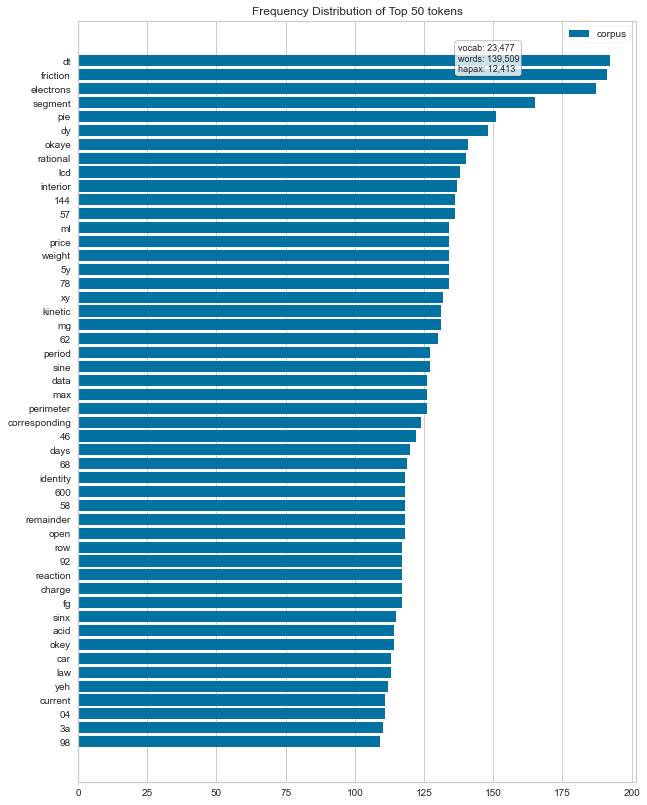

In [29]:
plt.figure(figsize=(10,14))
features = vectorizer_min.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(X_4)
visualizer.poof()

### **Bolsa de palabras resultantes**

In [30]:
# palabras que representen más de un 35% del total de palabras
vectorizer_max = CountVectorizer(min_df= 0.70)
#vectorizer = CountVectorizer(min_df= 0.005, max_df= 0.35)
X_5 = vectorizer_max.fit_transform(df_X)
# ¿cuál es la dimensión de la matriz dispersa?
print('Dimensión de la matriz dispersa \n.')
X_5.shape #o X.shape

Dimensión de la matriz dispersa 
.


(16305, 3)

### **Bolsa de palabras resultantes**

ValueError: shape mismatch: objects cannot be broadcast to a single shape

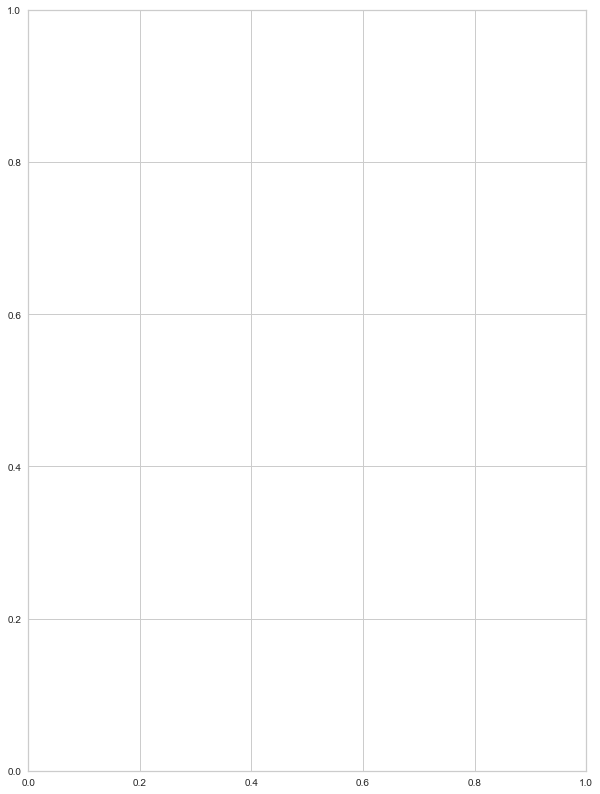

In [31]:
plt.figure(figsize=(10,14))
features = vectorizer_max.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(X_5)
visualizer.poof()

**Gráfico**

### **Cálculo de tf y tf–idf para unigramas**

El **tf** es la frecuencia de términos en un documento y el **idf** es la frecuencia inversa de un término en el conjunto de documentos. Antes de calcula dicha frecuencia, necesito vectorizar. 

**Aplico countVectorizer con unigramas**

Por defecto, trabaja con unigramas por lo tanto, no es necesario especificar el parámetro: ngram_range=(1, 1). 

In [32]:
unigrama_vectorizer = CountVectorizer(min_df=1)  #dejamos de lado las palabras de frecuencia 1
X_1 = unigrama_vectorizer.fit_transform(df_X)
# ¿cuál es la dimensión de la matriz dispersa?
print('Dimensión de la matriz dispersa \n.')
X_1  #o X.shape

Dimensión de la matriz dispersa 
.


<16305x24475 sparse matrix of type '<class 'numpy.int64'>'
	with 946735 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_1)
#print('Tamaño de la matriz',X_tfidf.shape)
print("Longitud del vector:", len(X_tfidf.toarray()[0]))


Longitud del vector: 24475


In [ ]:
 print(len(X_tfidf.toarray()[0]))

In [ ]:
print('Valores de la matriz con el cálculo de tf-idf \n')
print(X_tfidf.toarray())

**Aplico countVectorizer con bigramas**

En este caso, es necesario especificar el parámetro ngram_range=(2, 2).

In [34]:
bigrama_vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=1)  # dejamos de lado las palabras de frecuencia 1
X_2 = bigrama_vectorizer.fit_transform(df_X)
# ¿cuál es la dimensión de la matriz dispersa?
print('Dimensión de la matriz dispersa \n.')
X_2  #o X.shape


Dimensión de la matriz dispersa 
.


<16305x304481 sparse matrix of type '<class 'numpy.int64'>'
	with 1546304 stored elements in Compressed Sparse Row format>

In [38]:
print(bigrama_vectorizer.get_feature_names()[:20])    #Array mapping from feature integer indices to feature name.
#print('Valores del vector')
# print(X_2.toarray()) 

['00 00', '00 000', '00 000000010', '00 01', '00 022', '00 037', '00 06', '00 095', '00 0h', '00 10', '00 100', '00 1000', '00 10x', '00 1120', '00 12', '00 128', '00 15', '00 16', '00 19200', '00 23']


###**Cálculo de tf y tf–idf para bigramas**

In [42]:
tfidf_transformer = TfidfTransformer()
X_2_tfidf = tfidf_transformer.fit_transform(X_2)
#print('Tamaño de la matriz',X_2_tfidf.shape)

#print("Longitud del vector:", len(X_2_tfidf.toarray()[0]))


In [44]:
# print('Valores de la matriz con el cálculo de tf-idf \n')
#print(X_2_tfidf.toarray())

## 11. Conclusiones

Usando los tokens del tutor se obtuvo mejor desempeño en la detección de la clase minoritaria que usando todos los tokens y usando los tokens del estudiante

### **Referencias**

[Método CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

[Método TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)



[Método TfidfTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)

[Repo sobre Applied Text Analysis with Python](https://github.com/foxbook/atap
)

Vectorización:

https://learning.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html#ATAP04

https://learning.oreilly.com/library/view/applied-text-analysis/9781491963036/
 https://github.com/foxbook/atap/blob/master/snippets/ch04/vectorization.py

[Ejemplo de aplicación de CountVectorizer()](https://github.com/shreyans29/thesemicolon/blob/master/Text%20Analytics%20CV.ipynb)




